In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train', 'train.csv', 'sample_submission.csv', 'test']


In [2]:
#import the necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import zipfile as zf
import os
import csv
import gc
import operator
import random
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from random import shuffle
from IPython.display import Image
from pathlib import Path

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
import keras.backend as K
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


In [3]:
#reading train csv
df = pd.read_csv('/kaggle/input/train.csv')

In [4]:
df.shape
df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [5]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'/kaggle/input/train/train/{filename}') for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

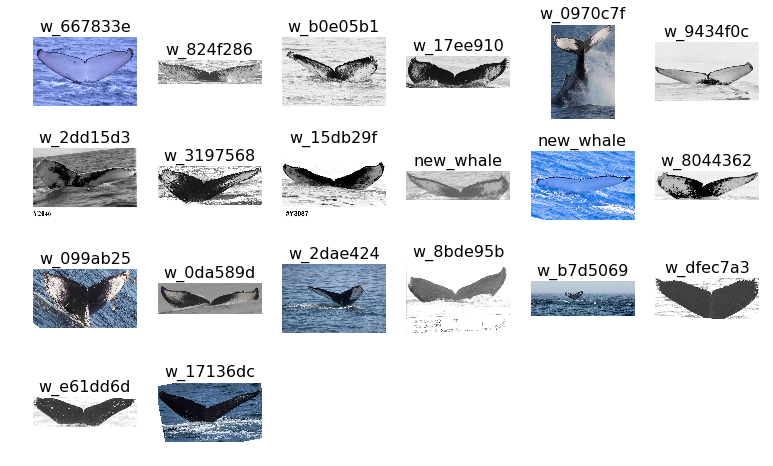

In [6]:
rand_rows = df.sample(frac=1.)[:20]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

In [7]:
import cv2
img = cv2.imread('../input/train/train/00022e1a.jpg')
img.shape

(500, 699, 3)

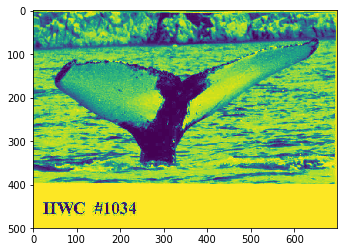

In [8]:
img = plt.imread('../input/train/train/00022e1a.jpg')
plt.imshow(img)

In [9]:
#need to convert y into on-hot encoded labels
def prepareY(Y):

    values = array(Y)
    print(values.shape)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)

    y = onehot_encoded
    print(y.shape)
    return y, label_encoder

In [10]:
Y = df['Id']

print("Shape Y-train: ", Y.shape)

#The next lines are used for testing - not necessary for the code
#labels = trainData['Id'].unique()
#print("Labels in data set: ", labels.shape)
#labelsTrain = Y.unique()
#print("Labels in training set: ", labelsTrain.shape)

y, label_encoder = prepareY(Y)

Shape Y-train:  (9850,)
(9850,)
[3741  310 3613 ... 2337  746 3088]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(9850, 4251)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_dataframe(
df,
directory = '../input/train/train',
x_col = 'Image',
y_col = 'Id',
target_size = (100,100),
class_mode = 'categorical'
)

Found 9850 images belonging to 4251 classes.


In [12]:
mod = Sequential()

mod.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

mod.add(BatchNormalization(axis = 3, name = 'bn0'))
mod.add(Activation('relu'))

mod.add(MaxPooling2D((2, 2), name='max_pool'))
mod.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
mod.add(Activation('relu'))
mod.add(AveragePooling2D((3, 3), name='avg_pool'))

mod.add(Flatten())
mod.add(Dense(500, activation="relu", name='rl'))
mod.add(Dropout(0.8))
mod.add(Dense(4251, activation='softmax', name='sm'))

print(mod.output_shape)

#opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
mod.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(None, 4251)


In [13]:
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)        0         
__________

In [14]:
train_generator

In [15]:
history = mod.fit_generator(
train_generator,
steps_per_epoch = 2000,
epochs = 15,
validation_steps = 64
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
2000/2000 [==============================] - 447s 224ms/step - loss: 7.7175 - acc: 0.0818
Epoch 2/15
2000/2000 [==============================] - 426s 213ms/step - loss: 6.7636 - acc: 0.0859
Epoch 3/15
2000/2000 [==============================] - 425s 212ms/step - loss: 5.1842 - acc: 0.1594
Epoch 4/15
2000/2000 [==============================] - 427s 213ms/step - loss: 3.4534 - acc: 0.3375
Epoch 5/15
2000/2000 [==============================] - 425s 212ms/step - loss: 2.2805 - acc: 0.5069
Epoch 6/15
1885/2000 [===========================>..] - ETA: 24s - loss: 1.6381 - acc: 0.6210

In [16]:
mod.save('CNNkeras.h5')

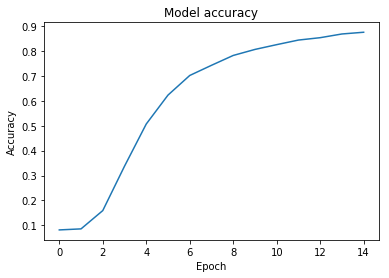

In [17]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [18]:
def prepareImages(data, m, dataset):
    
    print("Preparing images")
    
    X_train = np.zeros((m, 100, 100, 3))
    
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("../input/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    count = 0
    
    print("Finished!")
            
    return X_train

In [19]:
col = ['Image']
test_dir = os.listdir('/kaggle/input/test/test')
test = pd.DataFrame(test_dir,columns = col)


In [20]:
test.head()

,Image
0,cd72c9c4.jpg
1,f953b681.jpg
2,05df666d.jpg
3,874029cc.jpg
4,666e9b6f.jpg


In [21]:
print(len(test_dir))

15610


In [22]:
test = os.listdir("../input/test/test")
print(len(test))

#separate data into different DataFrames due to memory constraints
col = ['Image']
testData1 = pd.DataFrame(test[0:3899], columns=col)
testData2 = pd.DataFrame(test[3900:7799], columns=col)
testData3 = pd.DataFrame(test[7800:11699], columns=col)
testData4 = pd.DataFrame(test[11700:15609], columns=col)
testData = pd.DataFrame(test, columns=col)

15610


In [23]:
gc.collect()
X = prepareImages(testData1, 3900, "test/test")
X /= 255

Preparing images
Processing image:  1 ,  cd72c9c4.jpg
Processing image:  501 ,  0c1045b0.jpg
Processing image:  1001 ,  9bfb9a0e.jpg
Processing image:  1501 ,  806a584d.jpg
Processing image:  2001 ,  2a9e2c0b.jpg
Processing image:  2501 ,  6680fcde.jpg
Processing image:  3001 ,  0d1ddae8.jpg
Processing image:  3501 ,  61049d14.jpg
Finished!


In [24]:
predictions1 = mod.predict(np.array(X), verbose=1)
gc.collect()

3900/3900 [==============================] - 1s 265us/step


0

In [25]:
X = prepareImages(testData2, 3900, "test/test")
X /= 255
predictions2 = mod.predict(np.array(X), verbose=1)
gc.collect()

Preparing images
Processing image:  1 ,  a1d3509a.jpg
Processing image:  501 ,  1e96596a.jpg
Processing image:  1001 ,  b1e96c5d.jpg
Processing image:  1501 ,  47bb2249.jpg
Processing image:  2001 ,  53cfa7a2.jpg
Processing image:  2501 ,  2494f682.jpg
Processing image:  3001 ,  2566b085.jpg
Processing image:  3501 ,  2b9e12a0.jpg
Finished!
3900/3900 [==============================] - 1s 252us/step


0

In [26]:
X = prepareImages(testData3, 3900, "test/test")
X /= 255
predictions3 = mod.predict(np.array(X), verbose=1)
gc.collect()

Preparing images
Processing image:  1 ,  b62be85f.jpg
Processing image:  501 ,  cd629154.jpg
Processing image:  1001 ,  e46fdeae.jpg
Processing image:  1501 ,  15b0849d.jpg
Processing image:  2001 ,  6e3f835e.jpg
Processing image:  2501 ,  638c874f.jpg
Processing image:  3001 ,  ef26210a.jpg
Processing image:  3501 ,  08bd7ff9.jpg
Finished!
3900/3900 [==============================] - 1s 226us/step


0

In [27]:
X = prepareImages(testData4, 3910, "test/test")
X /= 255
predictions4 = mod.predict(np.array(X), verbose=1)
gc.collect()

Preparing images
Processing image:  1 ,  8863ac53.jpg
Processing image:  501 ,  ef0c487d.jpg
Processing image:  1001 ,  4b113374.jpg
Processing image:  1501 ,  6b141285.jpg
Processing image:  2001 ,  5debefbb.jpg
Processing image:  2501 ,  82244bbe.jpg
Processing image:  3001 ,  62cf5112.jpg
Processing image:  3501 ,  2453a567.jpg
Finished!
3910/3910 [==============================] - 1s 228us/step


0

In [28]:
predictions = np.concatenate((predictions1, predictions2), axis=0)
predictions = np.concatenate((predictions, predictions3), axis=0)
predictions = np.concatenate((predictions, predictions4), axis=0)
gc.collect()
print(predictions.shape)


(15610, 4251)


In [29]:
print(predictions.shape)

copy_pred = np.copy(predictions)
idx = np.argmax(copy_pred, axis=1)
copy_pred[:,idx] = 0
idx2 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx2] = 0
idx3 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx3] = 0
idx4 = np.argmax(copy_pred, axis=1)
copy_pred[:, idx4] = 0
idx5 = np.argmax(copy_pred, axis=1)

(15610, 4251)


In [30]:
#convert the one-hot vectors to their names
results = []

print(idx[0:10])
print(idx2[0:10])
print(idx3[0:10])
print(idx4[0:10])
print(idx5[0:10])
threshold = 0.05 #threshold - only consider answers with a probability higher than it
for i in range(0, predictions.shape[0]):
#for i in range(0, 10):
    each = np.zeros((4251, 1))
    each2 = np.zeros((4251, 1))
    each3 = np.zeros((4251, 1))
    each4 = np.zeros((4251, 1))
    each5 = np.zeros((4251, 1))
    if((predictions[i, idx5[i]] > threshold)):
        each5[idx5[i]] = 1
        each4[idx4[i]] = 1
        each3[idx3[i]] = 1
        each2[idx2[i]] = 1
        each[idx[i]] = 1
        tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0], label_encoder.inverse_transform([argmax(each4)])[0], label_encoder.inverse_transform([argmax(each5)])[0]]
    else:
        if((predictions[i, idx4[i]] > threshold)):
            print(predictions[i, idx4[i]])
            each4[idx4[i]] = 1
            each3[idx3[i]] = 1
            each2[idx2[i]] = 1
            each[idx[i]] = 1
            tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0], label_encoder.inverse_transform([argmax(each4)])[0]]
        else:
            if((predictions[i, idx3[i]] > threshold)):
                each3[idx3[i]] = 1
                each2[idx2[i]] = 1
                each[idx[i]] = 1
                tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0], label_encoder.inverse_transform([argmax(each3)])[0]]
            else:
                if((predictions[i, idx2[i]] > threshold)):
                    each2[idx2[i]] = 1
                    each[idx[i]] = 1
                    tags = [label_encoder.inverse_transform([argmax(each)])[0], label_encoder.inverse_transform([argmax(each2)])[0]]
                else:
                    each[idx[i]] = 1
                    tags = label_encoder.inverse_transform([argmax(each)])[0]
    results.append(tags)

[0 0 0 0 0 0 0 0 0 0]
[2074 1739 2580 3369 1739 3896 2602 2725 3360 1923]
[1277  255  866 3112 3115 1949 3115 2367 3112 2774]
[4010 3438 2181   95 1953 3711 1371 2181  411 3785]
[ 666 1195  625 2966 3412 3984 1114  406 4203 2013]


In [31]:
#write the predictions in a file to be submitted in the competition.
myfile = open('output.csv','w')

column= ['Image', 'Id']

wrtr = csv.writer(myfile, delimiter=',')
wrtr.writerow(column)

for i in range(0, testData.shape[0]):
    pred = ""
    if(len(results[i])==5):
        if (results[i][4]!=results[i][0]):
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3] + " " + results[i][4]
        else:
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3]
    else:
        if(len(results[i])==4):
            pred = results[i][0] + " " + results[i][1] + " " + results[i][2] + " " + results[i][3]
        else:
            if(len(results[i])==3):
                pred = results[i][0] + " " + results[i][1] + " " + results[i][2]
            else:
                if(len(results[i])==2):
                    pred = results[i][0] + " " + results[i][1]
                else:
                    pred = results[i]
            
    result = [testData['Image'][i], pred]
    #print(result)
    wrtr.writerow(result)
    
myfile.close()